In [ ]:
import datetime as dt
import functools

import arraylake as al
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import zarr

from aifs_modal_demo.app import app, run_forecast


@functools.lru_cache(maxsize=10)
def get_forecast_ds(group: str | None) -> xr.Dataset | None:
    """Get forecast dataset."""
    try:
        fds = xr.open_dataset(
            session.store, group=group, engine="zarr", zarr_format=3, chunks=None
        )
    except zarr.errors.GroupNotFoundError:
        print(f"❌ Forecast group not found: {group}")
        return None
    else:
        print(f"✅ opened forecast dataset: {group}")
        return fds


def make_cartopy_plot(
    arr: xr.DataArray,
    projection=ccrs.PlateCarree(),
    cmap="viridis",
    title=None,
    **kwargs,
):
    """
    Create a plot of an xarray.DataArray with cartopy coastlines and boundaries.

    Args:
        arr (xr.DataArray): The data to plot. Must have 1D 'lat' and 'lon' dims.
        projection (ccrs.Projection, optional): The cartopy projection for the map.
                                                Defaults to ccrs.PlateCarree().
        cmap (str, optional): The colormap to use. Defaults to 'viridis'.
        title (str, optional): The plot title. Defaults to arr.name.
        **kwargs: Additional keyword arguments passed to arr.plot().
    """
    # Create the figure and axes with the specified projection
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection=projection)

    # The data coordinates are in lat/lon, so we use PlateCarree transform
    # This tells cartopy how to interpret the data's coordinates
    data_transform = ccrs.PlateCarree()

    # Plot the data. xarray's plot function is cartopy-aware.
    arr.plot(
        ax=ax,
        transform=data_transform,
        cmap=cmap,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.7, "orientation": "horizontal", "pad": 0.05},
        **kwargs,
    )

    # Add geographic features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="black")

    # Add gridlines with labels for better context
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title("")

    return fig

In [ ]:
date = dt.datetime(2025, 9, 15, 0, tzinfo=dt.UTC)
lead_time = 96  # in hours

target_repo = "martibosch/aifs-modal-outputs"
target_branch = "main"

In [ ]:
# run a single forecast on modal
with app.run():
    run_forecast.remote(
        date,
        target_repo,
        lead_time=lead_time,
        target_branch=target_branch,
    )

In [ ]:
client = al.Client()
repo = client.get_repo(target_repo)
session = repo.readonly_session(target_branch)
root = zarr.open_group(session.store, mode="r", zarr_format=3)

  2026-02-11T10:41:38.675787Z  WARN aws_runtime::env_config::normalize: profile [plugins] ignored; sections in the AWS config file (other than [default]) must have a prefix i.e. [profile my-profile]
    at /home/conda/feedstock_root/build_artifacts/icechunk_1770097574484/_build_env/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/aws-runtime-1.5.18/src/env_config/normalize.rs:121



In [ ]:
# forecasts = ["00z", "06z", "12z", "18z"]
dates = list(root.group_keys())
dates.sort(reverse=True)
print(dates)

['2025-09-15']


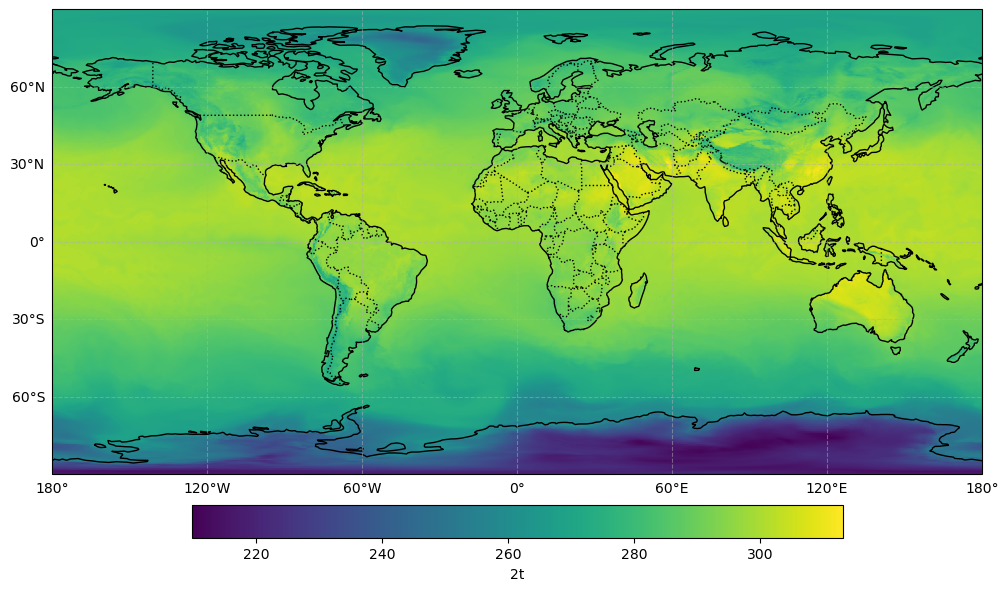

In [ ]:
forecast_group = "2025-09-15/00z"
variable = "2t"

forecast_ds = get_forecast_ds(forecast_group)
_ = make_cartopy_plot(forecast_ds[variable].isel(valid_time=0))

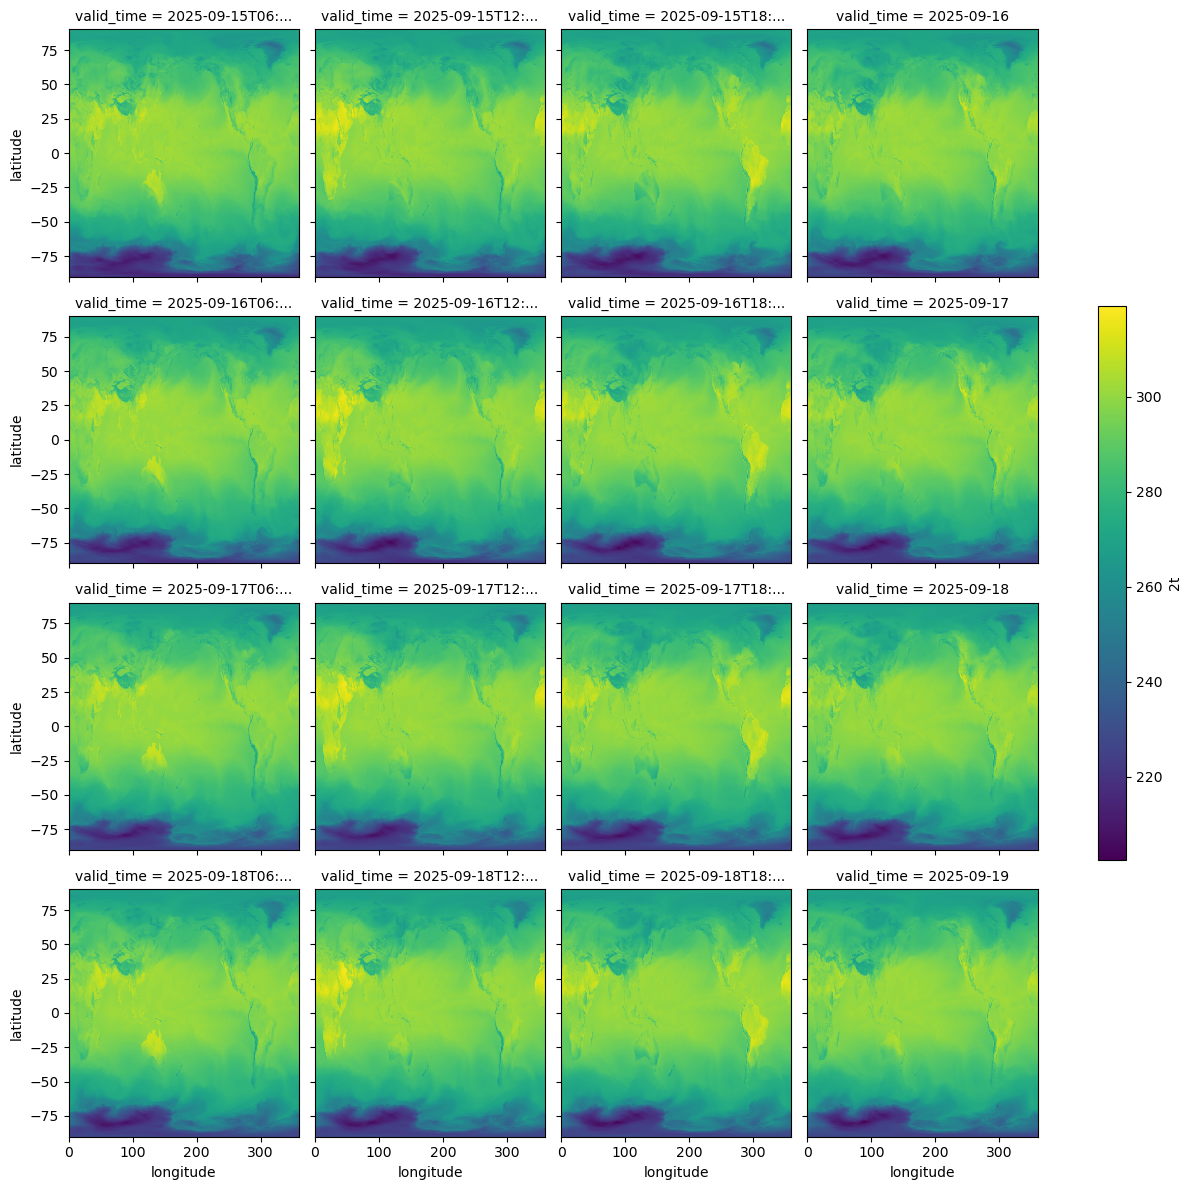

In [ ]:
forecast_ds[variable].plot(col="valid_time", col_wrap=4, cbar_kwargs={"shrink": 0.5})